# 1. Library 

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import plot_tss_results
print('Number of tissues: ',len(tissues))

from scipy.stats import zscore
from scipy.stats import iqr

('Number of tissues: ', 13)


In [2]:
save_dir = "Results/Figures/Silenced_CHO"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [3]:
pseudocount = 1

# 2. Load and Preprocessing

## Read in expression matrix

In [4]:
tissues_expr = pd.read_csv("Results/merged/tissues.merge.peaksexpression",sep="\t",index_col=0)
tissues_expr_log2 = np.log2(tissues_expr + pseudocount)
tissues_expr_log2.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
0,0.875780,0.000000,0.769772,0.704872,4.807149,6.412782,0.839960,1.669027,0.000000,0.000000,0.778209,1.646163,0.000000
1,0.000000,2.132577,2.314697,2.396434,0.000000,0.000000,1.383260,4.137230,1.070389,0.000000,0.627607,1.035624,0.000000
2,0.000000,1.173127,0.769772,2.329124,4.325099,0.000000,1.529785,1.759866,0.000000,2.735522,1.070389,1.521051,1.316146
3,0.875780,1.954196,2.008989,2.807355,1.422233,0.000000,2.296982,1.396890,0.000000,1.786596,1.319040,1.106572,1.759156
4,4.733354,6.484622,6.820817,7.103812,4.412240,0.000000,7.572197,5.699515,4.940167,2.134221,6.967514,5.480265,6.592457


### Read in promoter output

In [5]:
tss_meta = pd.read_csv("Results/output/TSS1.exp.meta",sep="\t",index_col=0)
tss_meta["Name"] = tss_meta.index
tss_meta.set_index("ID",inplace=True)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name
ID,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1


## Extract promoter peaks

In [6]:
prom_tissue = tissues_expr_log2.loc[tissues_expr_log2.index.isin(tss_meta.index)]
prom_tissue.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
4,4.733354,6.484622,6.820817,7.103812,4.412240,0.00000,7.572197,5.699515,4.940167,2.134221,6.967514,5.480265,6.592457
5,1.879706,5.107060,4.680887,3.378512,0.000000,0.00000,3.283710,4.247928,3.810786,1.090853,3.905447,4.053111,3.344828
6,2.933573,1.729009,3.963474,1.073820,1.818032,0.00000,1.161657,1.396890,5.456587,1.863938,3.269781,4.156504,2.746313
8,2.351911,2.360364,2.962549,3.078951,1.650765,2.82171,3.268178,2.814892,1.769772,3.620586,2.140779,2.039138,2.192194
12,0.000000,0.487486,0.000000,0.000000,0.000000,0.00000,0.000000,1.286881,2.748461,0.000000,0.589763,0.000000,0.000000


## Create median and max values


## Take the max transcript for the Gene (sum across tissues)
(Also should test the median)

In [7]:
tss_meta["Median"] = prom_tissue.median(axis=1)
tss_meta["Max"] = prom_tissue.max(axis=1)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max
ID,,,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1,1.182692,4.602884
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1,0.000000,1.073820
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1,0.000000,0.953576
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1,4.382667,11.955807
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1,0.847997,3.008630


In [8]:
gene_tissue = pd.DataFrame(index=tss_meta["Gene"].unique(), columns=prom_tissue.columns, dtype=float)
for ind, val in tqdm.tqdm_notebook(tss_meta.groupby("Gene")):
    gene_tissue.loc[ind] = prom_tissue.loc[prom_tissue.loc[val.index].sum(axis=1).idxmax()]
    
    
gene_tissue

Widget Javascript not detected.  It may not be installed or enabled properly.


,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Bmp4,6.276124,4.382667,2.510962,4.398145,0.000000,0.000000,2.099055,11.955807,6.414981,1.214125,4.074249,5.723194,5.673839
Cdkn3,0.000000,2.047887,1.666757,1.319040,3.008630,0.000000,1.184507,0.779610,0.000000,1.937344,0.847997,0.000000,0.000000
Cnih1,3.439623,3.804260,2.370164,3.876271,2.914565,2.794936,3.741698,4.626439,2.853330,4.350497,3.705425,3.133673,1.480265
Cgrrf1,3.722466,4.240696,4.378512,3.491853,5.463361,5.232661,4.573755,5.177918,6.001502,5.303781,4.623516,5.531901,3.067811
Samd4a,1.531069,2.260026,2.977280,2.744161,3.485427,0.000000,2.012824,3.316146,1.214125,0.000000,3.109361,2.592955,1.627607
Gch1,1.419539,1.978196,2.494416,1.454176,4.446256,2.950468,2.140779,2.510118,4.381745,2.253989,3.560715,3.133673,1.759156
Wdhd1,0.000000,2.253989,3.109361,2.161888,5.352617,2.422233,2.464295,2.082930,0.000000,3.485427,0.000000,1.613532,1.316146
Socs4,3.491212,3.404631,2.618239,3.008092,4.971773,3.240314,3.402878,4.209453,2.593752,3.733354,2.702658,3.707819,2.867896
Mapk1ip1l,2.109361,2.985500,2.308885,2.375735,2.350497,5.617651,3.695358,4.459432,2.941106,4.872829,2.681449,3.785202,1.857981
Lgals3,3.292045,5.978424,6.854868,5.856737,6.079378,7.566815,5.326301,6.067524,4.178183,8.205549,6.022035,5.037382,3.760221


# 3. Filter to genes of interest: DNA repair genes

In [9]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

# with open("../supplemental/dna_repair_genes/03_DNA_repair_genes.hamster.final.txt","r") as f:
#     repair_genes = [line.rstrip() for line in f]

repair_genes

['Mcm7', 'Ppp2r5a', 'Pias4', 'Pbrm1', 'Parp2']

In [10]:
tss_meta_dna_repair = tss_meta[tss_meta["Gene"].isin(repair_genes)]["Gene"].unique()

print("Number of repair genes in annotation", len(tss_meta[tss_meta["Gene"].isin(repair_genes)]["Gene"].unique()))
print("Number of overall repair genes", len(np.unique(np.array(repair_genes))))

not_found_in_anno = []
for i in repair_genes:
    if i not in tss_meta["Gene"].values:
        not_found_in_anno.append(i)

print("Number of repair genes not found in annotation", len(not_found_in_anno))


('Number of repair genes in annotation', 5)
('Number of overall repair genes', 5)
('Number of repair genes not found in annotation', 0)


In [11]:
gene_tissue = gene_tissue[gene_tissue.index.isin(repair_genes)]
gene_tissue.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Parp2,1.939227,2.171527,3.512859,2.502076,2.263034,0.000000,3.295723,2.453298,1.899176,2.996389,2.189034,2.051952,0.000000
Pbrm1,3.902074,3.095924,1.879706,3.125155,1.765535,2.709291,3.287092,2.622930,1.214125,3.125982,2.163499,1.981853,2.292782
Mcm7,3.443607,2.628774,2.613532,3.199280,0.000000,3.498251,3.265180,3.737687,2.969626,4.817623,3.862451,3.378512,1.316146
Ppp2r5a,4.956521,2.700440,3.121844,2.784504,1.392867,0.000000,2.462800,2.636915,2.584963,1.618239,4.638074,2.727557,2.651913
Pias4,1.666757,4.044394,3.608809,2.916477,1.695994,1.963474,3.321310,3.131480,1.783806,2.925999,2.609991,2.978806,3.366672


## Calculate Log2 Ratio

In [25]:
gene_tpm_ratio = (gene_tissue.drop("CHO",axis=1).mean(axis=1) - gene_tissue["CHO"])
gene_tpm_ratio

Parp2     -0.178763
Pbrm1      0.851166
Mcm7       3.227556
Ppp2r5a    1.347447
Pias4      1.163837
dtype: float64

In [18]:
gene_tissue.apply(lambda x: x.sum(), axis=1).sort_values().index

Index([u'Parp2', u'Pbrm1', u'Ppp2r5a', u'Pias4', u'Mcm7'], dtype='object')

In [22]:
curr_genes.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Parp2,1.939227,2.171527,3.512859,2.502076,2.263034,0.000000,3.295723,2.453298,1.899176,2.996389,2.189034,2.051952,0.000000
Pbrm1,3.902074,3.095924,1.879706,3.125155,1.765535,2.709291,3.287092,2.622930,1.214125,3.125982,2.163499,1.981853,2.292782
Ppp2r5a,4.956521,2.700440,3.121844,2.784504,1.392867,0.000000,2.462800,2.636915,2.584963,1.618239,4.638074,2.727557,2.651913
Pias4,1.666757,4.044394,3.608809,2.916477,1.695994,1.963474,3.321310,3.131480,1.783806,2.925999,2.609991,2.978806,3.366672
Mcm7,3.443607,2.628774,2.613532,3.199280,0.000000,3.498251,3.265180,3.737687,2.969626,4.817623,3.862451,3.378512,1.316146


In [23]:
gene_tissue.apply(lambda x: x.sum(), axis=1)

Parp2      27.274294
Pbrm1      33.165947
Mcm7       38.730667
Ppp2r5a    34.276636
Pias4      36.013968
dtype: float64

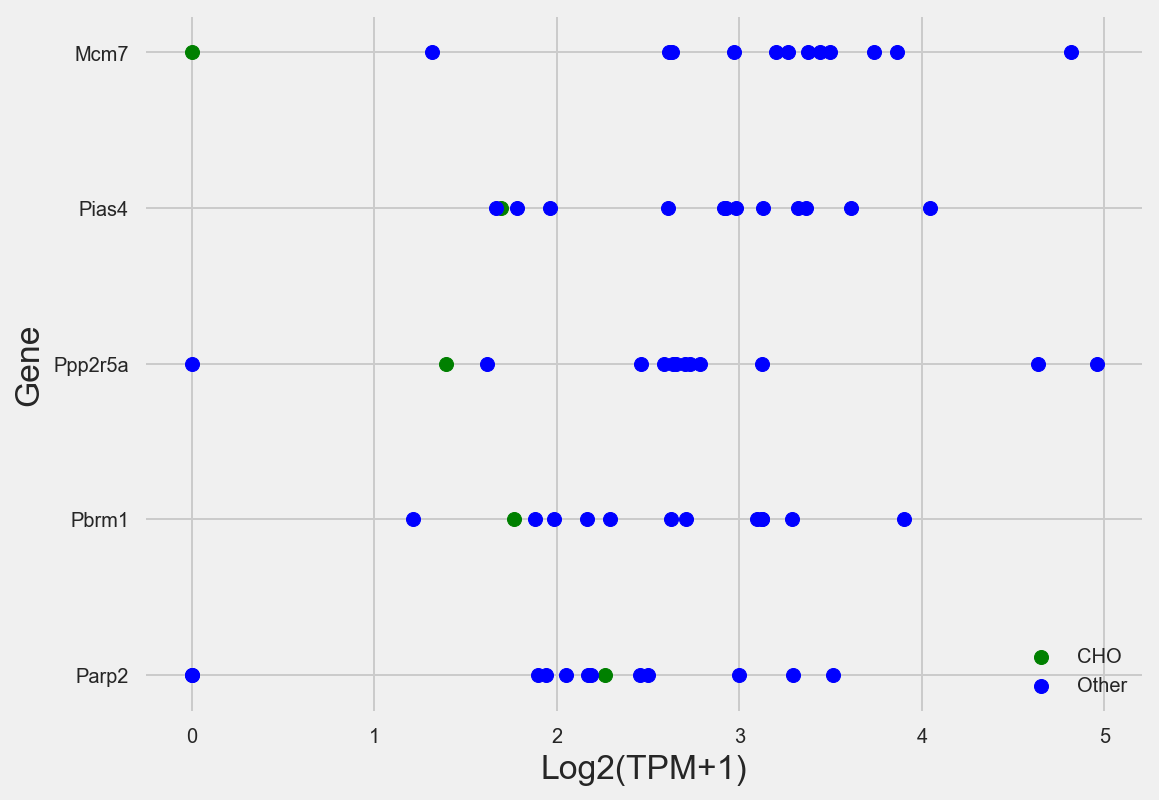

In [19]:

curr_order = gene_tissue.apply(lambda x: x.sum(), axis=1).sort_values().index
curr_genes = gene_tissue.loc[curr_order]
zip(range(len(curr_genes)), curr_genes.index)

# Construct scatter values
cho_scatter_x = []
cho_scatter_y = []
tissue_scatter_x = []
tissue_scatter_y = []
n_tissues = curr_genes.shape[1] - 1
for i in zip(range(len(curr_genes)), curr_genes.index):
    cho_scatter_y.append(i[0])
    cho_scatter_x.append(gene_tissue.loc[i[1],"CHO"])
    tissue_scatter_y += [i[0]] * n_tissues
    tissue_scatter_x += list(gene_tissue.drop("CHO",axis=1).loc[i[1]].values)


f, ax = plt.subplots()
ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
ax.scatter(tissue_scatter_x,tissue_scatter_y)
plt.ylabel("Gene")
plt.xlabel("Log2(TPM+1)")
ax.set_yticks(range(len(cho_scatter_y)))
ax.set_yticklabels(curr_genes.index.values);

plt.legend(["CHO","Other"])
name = os.path.join(save_dir,"repair_genes")


# Save
#     plt.savefig(name+"_log2.png")
#     plt.savefig(name+"_log2.eps")
#     curr_genes.to_csv(name + "_log2.txt")